In [1]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import ascii
import json
from IPython.display import display, Image
from specutils import Spectrum1D
from astropy import units, table
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from astropy.time import Time
import datetime
#Import Supernovae class and relevant functions
from Supernovae import *
import sncosmo
import mydefs
import iminuit

In [2]:
#Read in photometry file
hvw_photometry = pd.read_csv('../Data/16hvw_photometry/Marshal_lc.txt')
#Find indexes where photometry taken by P60
P60_indexes = np.where(hvw_photometry['instrument'] == "P60+SED-Machine")

#Filter dataframe for elements taken by P60
P60_photometry = hvw_photometry.iloc[P60_indexes]


In [3]:
#define function to grab items from df by filter
def grab_filter(DF, filt):
    indexes = np.where(DF['filter'] == filt)
    return DF.iloc[indexes]

def date_to_MJD(date):
    struct_time = [datetime.datetime.strptime(day,"%Y %b %d" ) for day in date]
    struct_time = Time(struct_time)
    struct_time.format = 'mjd'
    return struct_time.value


In [4]:
z_16hvw = .03663

MJD_max_16hvw = 57714.40

In [5]:
iPTF16hvw = Supernovae("iPTF16hvw" ,z_16hvw, MJD_max_16hvw)


In [24]:
#grab individual filters and store as Lightcurve objects
r_band = grab_filter(P60_photometry, 'r')
g_band = grab_filter(P60_photometry, 'g')
i_band = grab_filter(P60_photometry, 'i')
u_band = grab_filter(P60_photometry, 'u')

#Create Lightcurve objects out from data
iPTF16hvw.store_lightcurve(Lightcurve(date_to_MJD(r_band['date']), r_band['mag'], r_band['emag'], 'r'))
iPTF16hvw.store_lightcurve(Lightcurve(date_to_MJD(g_band['date']), g_band['mag'], g_band['emag'], 'g'))
iPTF16hvw.store_lightcurve(Lightcurve(date_to_MJD(i_band['date']), i_band['mag'], i_band['emag'], 'i'))
iPTF16hvw.store_lightcurve(Lightcurve(date_to_MJD(u_band['date']), u_band['mag'], u_band['emag'], 'u'))

g_band
#u_band

,date,jdobs,filter,absmag,mag,emag,limmag,instrument,reducedby,refsys,issub
257,2016 Nov 09,2.457702e+06,g,-16.58,19.40,0.08,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
260,2016 Nov 09,2.457702e+06,g,-16.61,19.38,0.05,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
264,2016 Nov 10,2.457703e+06,g,-17.05,18.93,0.05,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
268,2016 Nov 12,2.457705e+06,g,-17.70,18.29,0.03,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
272,2016 Nov 13,2.457706e+06,g,-17.98,18.00,0.03,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
276,2016 Nov 14,2.457707e+06,g,-18.15,17.83,0.02,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
280,2016 Nov 15,2.457708e+06,g,-18.25,17.73,0.03,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
284,2016 Nov 17,2.457710e+06,g,-18.48,17.50,0.03,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
292,2016 Nov 25,2.457718e+06,g,-18.58,17.40,0.02,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
296,2016 Nov 26,2.457719e+06,g,-18.53,17.45,0.02,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t


# Plot Photometry

In [7]:
#filter values with super high errorbars
good_vals = np.where(u_band['mag'] != 99)
u_band_clean = u_band.iloc[good_vals]

upper_lims = np.where(u_band['limmag'] != 99)
u_band_upper = u_band.iloc[upper_lims]

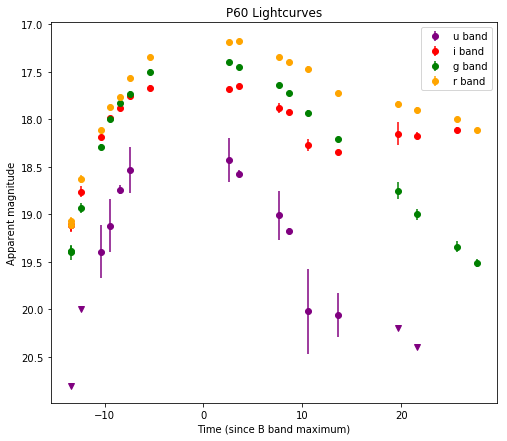

In [8]:
#Create one plot for all bands

f, ax = plt.subplots(figsize=(8,7))

plt.errorbar(date_to_MJD(u_band_clean['date']) - MJD_max_16hvw, u_band_clean['mag'], yerr = u_band_clean['emag'],label = 'u band', fmt='o', color='purple')
plt.errorbar(date_to_MJD(i_band['date']) - MJD_max_16hvw, i_band['mag'], yerr = i_band['emag'],label = 'i band', fmt='o', color='red')
plt.errorbar(date_to_MJD(g_band['date']) - MJD_max_16hvw, g_band['mag'], yerr = g_band['emag'],label = 'g band', fmt='o', color='green')
plt.errorbar(date_to_MJD(r_band['date']) - MJD_max_16hvw, r_band['mag'], yerr = r_band['emag'],label = 'r band', fmt='o', color= 'orange')
plt.errorbar(date_to_MJD(u_band_upper['date']) - MJD_max_16hvw, u_band_upper['limmag'],  fmt='v', color='purple', label=None)
ax.invert_yaxis()
plt.xlabel('Time (since B band maximum)')
plt.ylabel('Apparent magnitude')
plt.title('P60 Lightcurves')
plt.legend(loc=1, ncol=1)
plt.savefig('../Images/Photometry/P60_LC.pdf')
plt.show()


In [9]:
#Read in P48 data
P48_g = pd.read_csv('../Data/16hvw_photometry/P48_g.csv')
P48_R = pd.read_csv('../Data/16hvw_photometry/P48_R.csv')


In [10]:
#get rid of bad vals
g_clean = np.where(P48_g['mag_unc'] < 99)
P48_g_clean = P48_g.iloc[g_clean]

R_clean = np.where(P48_R['mag_unc'] < 99)
P48_R_clean = P48_R.iloc[R_clean]

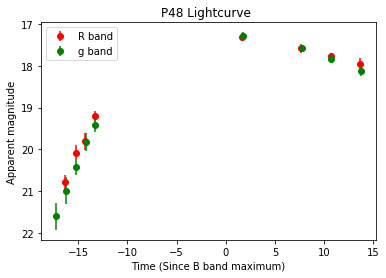

In [11]:
#plot light curves
f, ax = plt.subplots()
ax.invert_yaxis()
plt.errorbar(P48_R_clean['MJD'] - MJD_max_16hvw, P48_R_clean['mag'], yerr=P48_R_clean['mag_unc'],color='r', label='R band', fmt='o')
plt.errorbar(P48_g_clean['MJD'] - MJD_max_16hvw, P48_g_clean['mag'], yerr=P48_g_clean['mag_unc'], color='g', label='g band', fmt='o')
plt.xlabel('Time (Since B band maximum)')
plt.ylabel('Apparent magnitude')
plt.title('P48 Lightcurve ')
plt.legend()
plt.show()

# Absolute magnitude photometry - correct for extinction


In [12]:
#SDSS filters Extinction values from NED
u_ext = 0.63500000
g_ext = 0.49500000
i_ext = 0.25400000
r_ext = 0.34200000

extinctions = {'u' : u_ext, 'g' : g_ext, 'i' : i_ext, 'r' : r_ext}

#Host galaxy redshift
z_host = 0.03663

#Luminosity distance in pc
d_L = 168.309 * 10**6

d_mod = 5*np.log10(d_L) - 5

In [13]:
#define function to convert to absolute magnitude
def to_abs_mag(app_mag, band):
    return app_mag - d_mod - extinctions[band]


In [14]:
#convert to absolute magnitude
P60_g_abs = [to_abs_mag(app_mag, 'g') for app_mag in g_band['mag']]
P60_r_abs = [to_abs_mag(app_mag, 'r') for app_mag in r_band['mag']]
P60_u_abs =[to_abs_mag(app_mag, 'u') for app_mag in u_band_clean['mag']]
P60_i_abs = [to_abs_mag(app_mag, 'i') for app_mag in i_band['mag']]
P60_u_upper_lims = [to_abs_mag(app_mag, 'u') for app_mag in u_band_upper['limmag']]

P48_g_abs = [to_abs_mag(app_mag, 'g') for app_mag in P48_g_clean['mag']]
P48_R_abs = [to_abs_mag(app_mag, 'r') for app_mag in P48_R_clean['mag']]

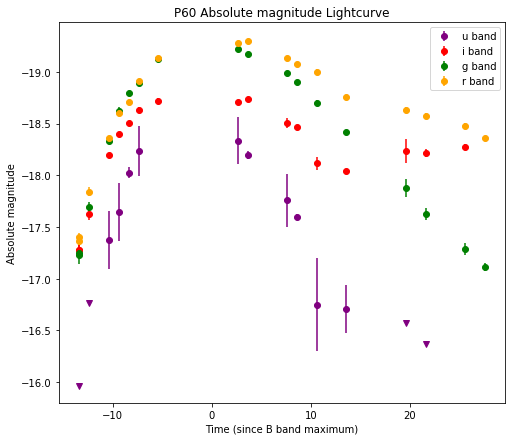

In [15]:
#Create one plot for all bands

f, ax = plt.subplots(figsize=(8,7))
#plot iPTF16hvw colors
plt.errorbar(date_to_MJD(u_band_clean['date']) - MJD_max_16hvw, P60_u_abs, yerr =u_band_clean['emag'] ,label = 'u band', fmt='o', color='purple')
plt.errorbar(date_to_MJD(i_band['date']) - MJD_max_16hvw, P60_i_abs, yerr = i_band['emag'],label = 'i band', fmt='o', color='red')
plt.errorbar(date_to_MJD(g_band['date']) - MJD_max_16hvw,P60_g_abs, yerr = g_band['emag'],label = 'g band', fmt='o', color='green')
plt.errorbar(date_to_MJD(r_band['date']) - MJD_max_16hvw, P60_r_abs, yerr= r_band['emag'],label = 'r band', fmt='o', color= 'orange')
plt.errorbar(date_to_MJD(u_band_upper['date']) - MJD_max_16hvw, P60_u_upper_lims,  fmt='v', color='purple', label=None)

#plot 




ax.invert_yaxis()
plt.xlabel('Time (since B band maximum)')
plt.ylabel('Absolute magnitude')
plt.title('P60 Absolute magnitude Lightcurve')
plt.legend(loc=1, ncol=1)
plt.savefig('../Images/Photometry/P60_Absolute_LC.pdf')
plt.show()


# SN2011fe sncosmo model


In [16]:
#Load in 2011fe Model
MJD_max_2011fe = 55814
z_2011fe = 0.000804


#Load in 2011fe Model
model = sncosmo.Model(source="snf-2011fe")

#set the known parameters
model.set(z = z_2011fe, t0=MJD_max_2011fe)

#Get phases to calc 2011fe Mag
dates = np.linspace(MJD_max_2011fe - 14, MJD_max_2011fe + 29, 70)


In [29]:
#Get simulated magnitudes for various bands of interest
fe_r = model.bandmag('sdssr', 'ab', dates)
fe_g = model.bandmag('sdssg', 'ab', dates)
fe_i = model.bandmag('sdssi', 'ab', dates)


#Incorporate Blue portion of U band
fname11fe = 'sn2011fe_1a.v3.2.dat'
t = np.loadtxt('../Data/' + fname11fe)

phase = np.unique(t[:,0])
disp = np.unique(t[:,1])
nphase, = phase.shape
ndisp, = disp.shape
dflux = np.reshape(t[:,2],(nphase,ndisp))

mfe = sncosmo.StretchSource(phase, disp, dflux)

mF = sncosmo.Model(source=mfe)
mF.set(z=z_2011fe, t0=MJD_max_2011fe)
fe_u = mF.bandmag('sdssu', 'ab', dates)
g_band


,date,jdobs,filter,absmag,mag,emag,limmag,instrument,reducedby,refsys,issub
257,2016 Nov 09,2.457702e+06,g,-16.58,19.40,0.08,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
260,2016 Nov 09,2.457702e+06,g,-16.61,19.38,0.05,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
264,2016 Nov 10,2.457703e+06,g,-17.05,18.93,0.05,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
268,2016 Nov 12,2.457705e+06,g,-17.70,18.29,0.03,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
272,2016 Nov 13,2.457706e+06,g,-17.98,18.00,0.03,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
276,2016 Nov 14,2.457707e+06,g,-18.15,17.83,0.02,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
280,2016 Nov 15,2.457708e+06,g,-18.25,17.73,0.03,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
284,2016 Nov 17,2.457710e+06,g,-18.48,17.50,0.03,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
292,2016 Nov 25,2.457718e+06,g,-18.58,17.40,0.02,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t
296,2016 Nov 26,2.457719e+06,g,-18.53,17.45,0.02,99.0,P60+SED-Machine,Fremling Automated Pipeline SEDM,SDSS,t


# Color evolution

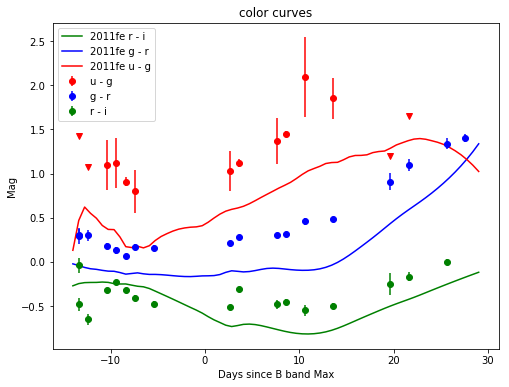

In [39]:
#Get indices of common epochs
index_u_g = []
for date in u_band_clean['date']:
    index_u_g.append( np.where(g_band['date'] == date)[0][0])
    
    
#get upper lim indices for u
upper_indices = np.where(u_band['limmag'] != 99.0)
u_upper = u_band.iloc[upper_indices]
g_upper = g_band.iloc[[1,2,-3,-4] ]

#filter for common dates
g = g_band.iloc[index_u_g]
u_g_color = np.array(u_band_clean['mag']) - np.array(g['mag'])


#plot color curve
f, ax  = plt.subplots(figsize=(8,6))
plt.xlabel('Days since B band Max')
plt.ylabel('Mag')
plt.title('color curves')

u_g_error = np.sqrt(np.array(u_band_clean['emag']**2) + np.array(g['emag']**2))
g_r_error = np.sqrt(np.array(r_band['emag']**2) + np.array(g_band['emag']**2))
r_i_error = np.sqrt(np.array(r_band['emag'][1:]**2) + np.array(i_band['emag']**2))


plt.errorbar(date_to_MJD(u_upper['date']) - MJD_max_16hvw, np.array(u_upper['limmag']) - np.array(g_upper['mag']),  fmt='v', color='red', label=None)
plt.errorbar(dates - MJD_max_2011fe, fe_r - fe_i, label='2011fe r - i', color='green' )
plt.errorbar(dates - MJD_max_2011fe, fe_g - fe_r, label = '2011fe g - r' ,color='blue')
plt.errorbar(dates - MJD_max_2011fe,  fe_u - fe_g, label='2011fe u - g', color='red' )

plt.errorbar(date_to_MJD(g['date']) - MJD_max_16hvw, u_g_color, yerr=u_g_error, color='red', label='u - g' ,fmt='o')
plt.errorbar(date_to_MJD(g_band['date']) - MJD_max_16hvw, np.array(g_band['mag']) - np.array(r_band['mag']),yerr=g_r_error,label= 'g - r',color='blue', fmt='o')
plt.errorbar(date_to_MJD(i_band['date']) - MJD_max_16hvw, np.array(r_band['mag'][1:]) - np.array(i_band['mag']),yerr=r_i_error,label='r - i', fmt='o', color='green')
plt.legend()
plt.savefig('../Images/color_curve')
plt.show()

# iPTF16hvw sncosmo fits

In [37]:
#Create copy of P60 data
sncosmo_photometry = P60_photometry.copy()


260   NaN
261   NaN
264   NaN
265   NaN
328   NaN
329   NaN
332   NaN
333   NaN
dtype: float64

In [83]:
#define conversion functions
def mag_to_flux(mag):
    return (10**(mag / -2.5))*3631

def mag_unc_to_flux_unc(flux, mag_unc):
    const = np.log(10) / 1.5
    return const* flux*mag_unc



In [84]:
#drop unnecessary columns
sncosmo_photometry.drop(columns=['jdobs', 'instrument', 'reducedby', 'refsys', 'limmag', 'absmag', 'issub '], inplace=True)
#drop values with mag == 99
bad_vals = np.where(sncosmo_photometry['mag'] > 90)[0]
sncosmo_photometry.drop(index=sncosmo_photometry.iloc[bad_vals].index, inplace=True)

#convert dates to MJD
sncosmo_photometry['date'] = date_to_MJD(sncosmo_photometry['date'])

#convert to fluxes and flux errors
sncosmo_photometry['flux'] = [mag_to_flux(mag) for mag in sncosmo_photometry['mag']]
sncosmo_photometry['fluxerr'] = [mag_unc_to_flux_unc(flux, mag_unc) for flux, mag_unc in zip(sncosmo_photometry['flux'],sncosmo_photometry['emag'])]
sncosmo_photometry.drop(columns=['mag', 'emag'], inplace=True)

#set zeropoint
sncosmo_photometry['zp'] = 2.5*np.log10(3631)
#set mag system to ab
sncosmo_photometry['zpsys'] = 'ab'



In [85]:
sncosmo.write_lc(sncosmo_photometry, 'full_photom.txt')
full_photom = sncosmo.read_lc('full_photom.txt')


In [86]:
#Create salt2 fit for iPTF16hvw
model_16hvw = sncosmo.Model(source='salt2')

#set known redshift for 16hvw
model_16hvw.set(z=z_16hvw)


result_full, fitted_model = sncosmo.fit_lc(
    full_photom, model_16hvw,
    ['t0', 'x0', 'x1', 'c'],
    bounds={"t0": (57705, 57725), 
            "x1": (-5, 5)}, guess_t0=True)  
print(result_full.parameters)
print(result_full.ndof)

[ 3.66300000e-02  5.77144134e+04  1.82463759e-03 -1.80167216e-01
  2.02145407e-01]
59


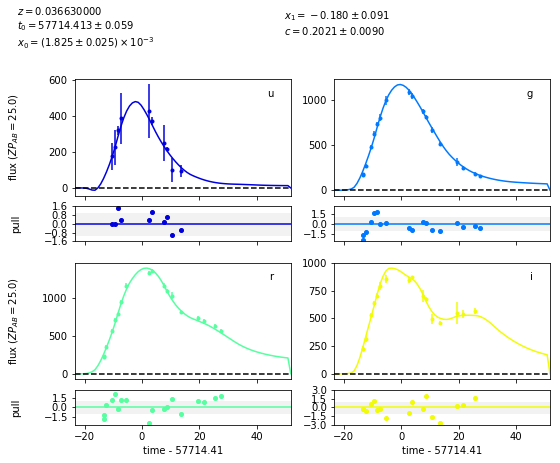

In [87]:
sncosmo.plot_lc(full_photom, model=fitted_model, errors=result_full.errors)

In [88]:
#Fit without early data
late_indices = np.where(full_photom['date'] > MJD_max_16hvw - 10
                       
            )

In [89]:
late_photom = full_photom[late_indices]

In [90]:
result_late, fitted_model_late = sncosmo.fit_lc(
   late_photom, model_16hvw,
    ['t0', 'x0', 'x1', 'c'],
    bounds={"t0": (57705, 57725), 
            "x1": (-5, 5)}, guess_t0=True)  
print(result_late.parameters)
print(result_late.ndof)

[3.66300000e-02 5.77143800e+04 1.79284983e-03 7.13644386e-02
 2.11198275e-01]
46


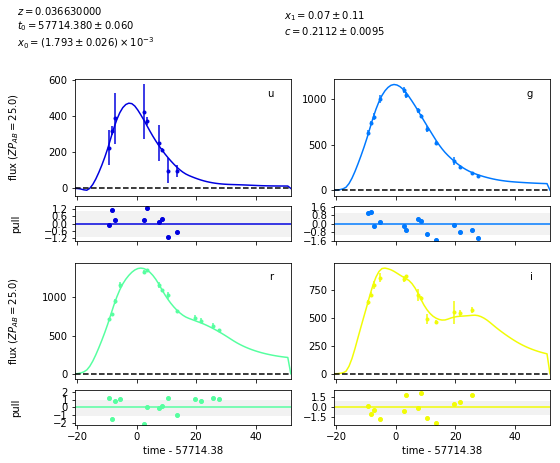

In [91]:
sncosmo.plot_lc(late_photom, model=fitted_model_late, errors=result_late.errors)